In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree     import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

In [3]:
from sklearn.datasets        import make_moons, make_circles, make_classification
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors       import ListedColormap
from sklearn.inspection      import DecisionBoundaryDisplay

In [4]:
def generate_datasets():
    X, y = make_classification(
            n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
        )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    datasets = [
            make_moons(noise=0.2, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable,
        ]
    return datasets

In [5]:
def visualize(classifiers,names):
    datasets = generate_datasets()

    figure = plt.figure(figsize=(22,9))
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        # Plot the testing points
        ax.scatter(
            X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
        )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            DecisionBoundaryDisplay.from_estimator(
                clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
            )

            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="black",
                alpha=0.9,
            )

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            
            ax.text(
                x_max - 0.3,
                y_min + 0.3,
                ("%.2f" % score).lstrip("0"),
                size=15,
                horizontalalignment="right",
            )
            i += 1

    #plt.tight_layout()
    plt.savefig("comparison.svg")
    plt.show()
    

In [6]:
#Decision tree parameters
max_depth         = 4
min_samples_split = 2
min_samples_leaf  = 1
criterion         = ["gini", "entropy", "log_loss"][2]
splitter          = ["best","random"][0]

#Ensemble parameters
learning_rate     = 0.04
n_estimators      = 80

#Gradient boost
loss = ["log_loss","deviance","exponential"][0]

#XGBoosting parameters
gamma            = 0.9
subsample        = 1
colsample_bytree = 0.7
lambda_          = 1 
alpha_           = 0

classifiers = [
    DecisionTreeClassifier(
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            criterion=criterion,
                            splitter =splitter
                          ),
    
    AdaBoostClassifier(  
                         DecisionTreeClassifier(
                                                max_depth=max_depth,
                                                min_samples_split=min_samples_split,
                                                criterion=criterion,
                                                splitter=splitter
                                                ),
                         n_estimators=n_estimators
                      ),
    
    BaggingClassifier(   
                         DecisionTreeClassifier(
                                                max_depth=max_depth,
                                                min_samples_split=min_samples_split,
                                                criterion=criterion,
                                                splitter=splitter
                                                ),
                         n_estimators=n_estimators
                     ),
    
    RandomForestClassifier(  
                             max_depth=max_depth,                  
                             n_estimators=n_estimators
                          ),
    
    ExtraTreesClassifier(max_depth=max_depth),
    
    GradientBoostingClassifier(
                                loss=loss,
                                n_estimators=n_estimators,
                                max_depth=max_depth
                              ),
    
    XGBClassifier( 
                   max_depth        = max_depth,
                   n_estimators     = n_estimators,
                   reg_lambda       = lambda_,
                   gamma            = gamma,
                   subsample        = subsample,
                   colsample_bytree = colsample_bytree
                  )
]

names = [
            "DecisionTreeClassifier",
            "AdaBoostClassifier",
            "BaggingClassifier",
            "RandomForestClassifier",
            "ExtraTreesClassifier",
            "GradientBoostingClassifier",
            "XGBClassifier"
        ]

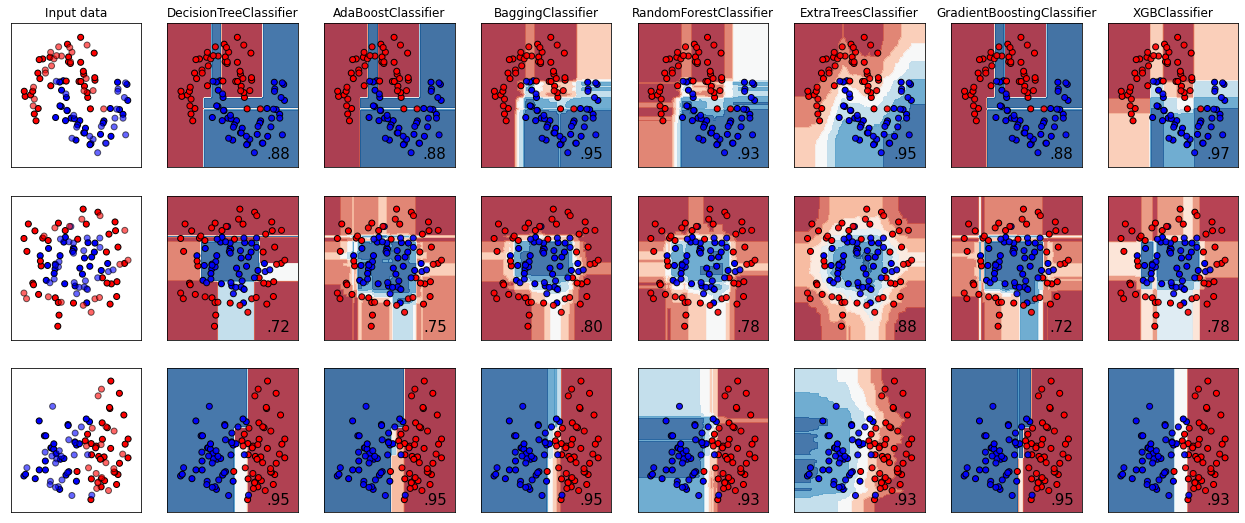

In [7]:
visualize(classifiers,names)

In [8]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def evaluate_performance(modelo, nome, X, y, cv):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)
    print("Performance de {}:\t{:0.4} ± {:0.4}".format( \
        nome, s.mean().round(3), s.std().round(3)))

In [9]:
datasets = generate_datasets()


for ds_cnt, ds in enumerate(datasets):
    print("Dataset ",ds_cnt) 
    X, y = ds
    X = StandardScaler().fit_transform(X)
    for classifier,name in zip(classifiers,names):
        cv = StratifiedKFold(n_splits=10, random_state=41, shuffle=True)
        evaluate_performance(classifier,name,X, y,cv)

Dataset  0
Performance de DecisionTreeClassifier:	0.85 ± 0.12
Performance de AdaBoostClassifier:	0.93 ± 0.119
Performance de BaggingClassifier:	0.93 ± 0.11
Performance de RandomForestClassifier:	0.92 ± 0.087
Performance de ExtraTreesClassifier:	0.92 ± 0.108
Performance de GradientBoostingClassifier:	0.92 ± 0.14
Performance de XGBClassifier:	0.91 ± 0.122
Dataset  1
Performance de DecisionTreeClassifier:	0.85 ± 0.092
Performance de AdaBoostClassifier:	0.83 ± 0.11
Performance de BaggingClassifier:	0.89 ± 0.083
Performance de RandomForestClassifier:	0.86 ± 0.08
Performance de ExtraTreesClassifier:	0.89 ± 0.083
Performance de GradientBoostingClassifier:	0.83 ± 0.11
Performance de XGBClassifier:	0.84 ± 0.066
Dataset  2
Performance de DecisionTreeClassifier:	0.93 ± 0.046
Performance de AdaBoostClassifier:	0.9 ± 0.077
Performance de BaggingClassifier:	0.93 ± 0.064
Performance de RandomForestClassifier:	0.94 ± 0.049
Performance de ExtraTreesClassifier:	0.93 ± 0.064
Performance de GradientBoosti